In [1]:
# Imports and plotting setups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math

import sys, os
sys.path.insert(0, '../../')
sys.path.insert(0, '../')

import math_funcs

from cycler import cycler

default_cycler = (cycler(color=['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', 'black']) +
                cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':']))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

plt.rcParams["font.family"] = "Times"
plt.rcParams["font.size"] = 8

plt.rcParams['figure.figsize'] = (3.5, 2.5)
plt.rcParams['figure.dpi'] = 200

plt.rcParams['text.usetex'] = True

from scipy.constants import (
    epsilon_0,   # Permittivity of free space (vacuum)
    mu_0,        # Permeability of free space (vacuum)
    c,           # Speed of light in vacuum
    #e,           # Elementary charge
    #h,           # Planck constant
    #hbar,        # Reduced Planck constant (h-bar)
    k,           # Boltzmann constant
    #G,           # Newtonian constant of gravitation
    #m_e,         # Electron mass
    #m_p,         # Proton mass
    #m_n,         # Neutron mass
    #alpha,       # Fine-structure constant
    eV,          # Electron volt
)

# Example usage of some constants
print(f"Permittivity of free space: {epsilon_0} F/m")
print(f"Permeability of free space: {mu_0} N/A^2")
print(f"Speed of light in vacuum: {c} m/s")
# print(f"Elementary charge: {e} C")
# print(f"Planck constant: {h} J·s")
# print(f"Reduced Planck constant: {hbar} J·s")
print(f"Boltzmann constant: {k} J/K")
# print(f"Newtonian constant of gravitation: {G} m^3/kg/s^2")
# print(f"Electron mass: {m_e} kg")
# print(f"Proton mass: {m_p} kg")
# print(f"Neutron mass: {m_n} kg")
# print(f"Fine-structure constant: {alpha}")
print(f"Electron volt: {eV} J")

def print_engineering_notation(value):
    """
    Print a value in engineering notation (powers of ten in multiples of 3).

    Parameters:
    value (float): The value to be printed in engineering notation.
    """
    
    if value == 0:
        print("0")
        return

    exponent = int(math.floor(math.log10(abs(value)) / 3) * 3)
    mantissa = value / (10 ** exponent)
    
    print(f"{mantissa:.3f}e{exponent}")

# Example usage
print_engineering_notation(0)          # Output: 0
print_engineering_notation(1234.56)    # Output: 1.235e3
print_engineering_notation(0.00123456) # Output: 1.235e-3
print_engineering_notation(-987654)    # Output: -987.654e3
print_engineering_notation(1e9)        # Output: 1.000e9

Permittivity of free space: 8.8541878128e-12 F/m
Permeability of free space: 1.25663706212e-06 N/A^2
Speed of light in vacuum: 299792458.0 m/s
Boltzmann constant: 1.380649e-23 J/K
Electron volt: 1.602176634e-19 J
0
1.235e3
1.235e-3
-987.654e3
1.000e9


In [2]:
#Define coldspace, jovian, gal radiation field for a mission 
T_B_J_low_band = 10**11 #K
T_B_J_high_band = 10**2 # K
T_B_gal_low_band = 10**7 # K
T_B_gal_high_band = T_B_J_high_band
T_B_coldspace = 2.7 #K

In [3]:
# Define the theta and phi sampling grid
theta = np.arange(0, 181, 1, dtype=int) # deg
phi = np.arange(0, 361, 1, dtype=int) # deg

phi_grid, theta_grid  = np.meshgrid(phi, theta)

# The orientation of the coordinate system is taken such that
# Europa's equator is theta==90, and all phi
# The sub Jovian point is located at theta==90, phi==0
# The anti Jovian point is located at theta==90, phi==180
# The north pole is located at theta==0
# The south pole is located at theta==180

In [18]:
# Define the brightness grid with vertical and horizontal polarization
brightness_field_of_europan_sky_vertical_low_band = np.zeros_like(theta_grid, dtype=float).flatten()
brightness_field_of_europan_sky_horizontal_low_band = np.zeros_like(theta_grid, dtype=float).flatten()
brightness_field_of_europan_sky_vertical_high_band = np.zeros_like(theta_grid, dtype=float).flatten()
brightness_field_of_europan_sky_horizontal_high_band = np.zeros_like(theta_grid, dtype=float).flatten()
for i in np.arange(theta_grid.size):
    theta = theta_grid.flatten()[i]
    phi = phi_grid.flatten()[i]

    brightness_field_of_europan_sky_vertical_low_band[i] += 0.5 * T_B_coldspace
    brightness_field_of_europan_sky_horizontal_low_band[i] += 0.5 * T_B_coldspace
    brightness_field_of_europan_sky_vertical_high_band[i] += 0.5 * T_B_coldspace
    brightness_field_of_europan_sky_horizontal_high_band[i] += 0.5 * T_B_coldspace

    # DAM radiation illumination (from aural regions of jupiter only)
    if theta == (90 - 6) or theta == (90 + 6):
        if phi == 0:
            brightness_field_of_europan_sky_vertical_low_band[i] += 0.5 * T_B_J_low_band
            brightness_field_of_europan_sky_horizontal_low_band[i] += 0.5 * T_B_J_low_band

    # DIM radiation illumination (from jupiter itself directly)
    if theta >= (90 - 6) and theta <= (90 + 6):
        if phi >= (360 - 6) or phi <= 6:
            brightness_field_of_europan_sky_vertical_high_band[i] += 0.5 * T_B_J_high_band
            brightness_field_of_europan_sky_horizontal_high_band[i] += 0.5 * T_B_J_high_band

    # Assume Europa is on the antisolar side of europa
    # The galactic background is then assumed to be a 30 deg
    # wide band of radiation illuminating the antiJovian side of Europa
    # 60 degrees north of the equator of Europa
    if theta >= 45 and theta <= 75:
        if phi >= 90 and phi <= 270:
            brightness_field_of_europan_sky_vertical_low_band[i] += 0.5 * T_B_gal_low_band
            brightness_field_of_europan_sky_horizontal_low_band[i] += 0.5 * T_B_gal_low_band
            
            brightness_field_of_europan_sky_vertical_high_band[i] += 0.5 * T_B_gal_high_band
            brightness_field_of_europan_sky_horizontal_high_band[i] += 0.5 * T_B_gal_high_band

brightness_field_of_europan_sky_vertical_low_band = brightness_field_of_europan_sky_vertical_low_band.reshape(theta_grid.shape)
brightness_field_of_europan_sky_horizontal_low_band = brightness_field_of_europan_sky_horizontal_low_band.reshape(theta_grid.shape)
brightness_field_of_europan_sky_vertical_high_band = brightness_field_of_europan_sky_vertical_high_band.reshape(theta_grid.shape)
brightness_field_of_europan_sky_horizontal_high_band = brightness_field_of_europan_sky_horizontal_high_band.reshape(theta_grid.shape)

In [19]:
brightness_field_of_europan_sky_horizontal_high_band[90, 1], 0.5 * T_B_J_high_band

(np.float64(51.35), 50.0)

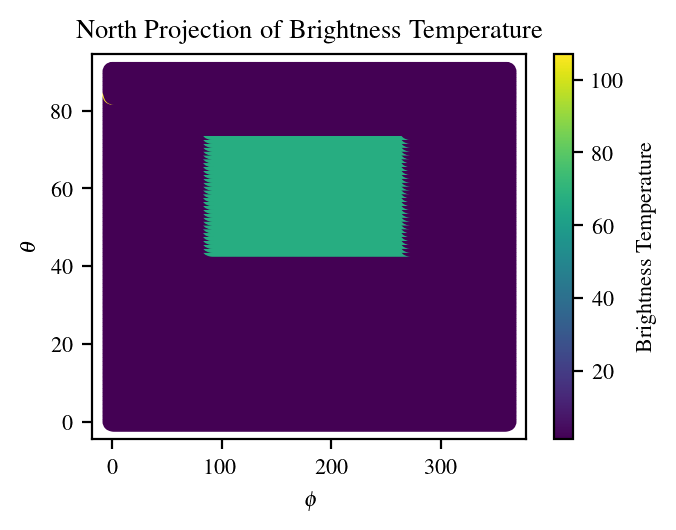

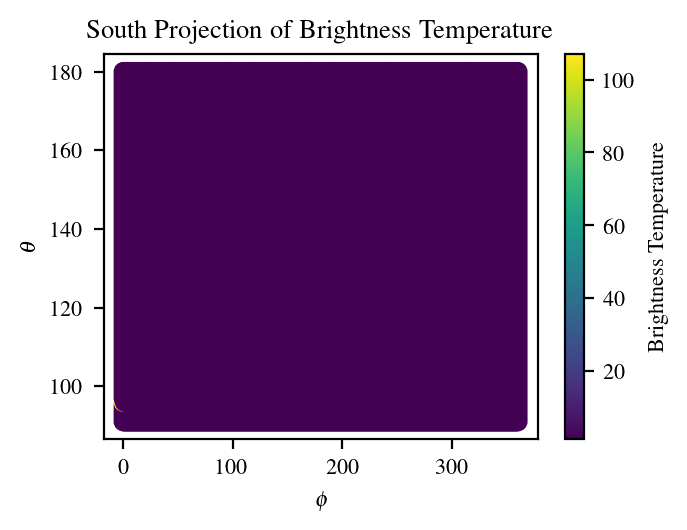

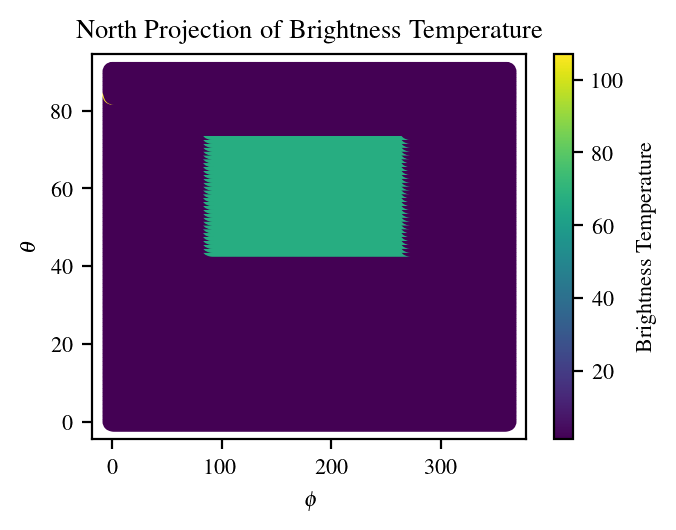

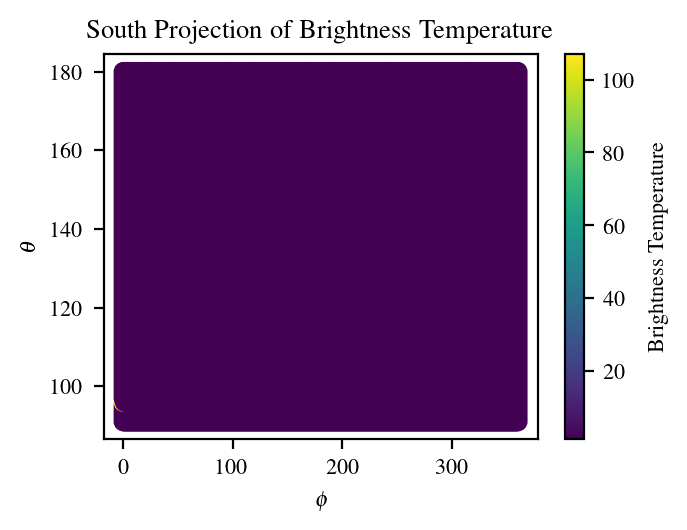

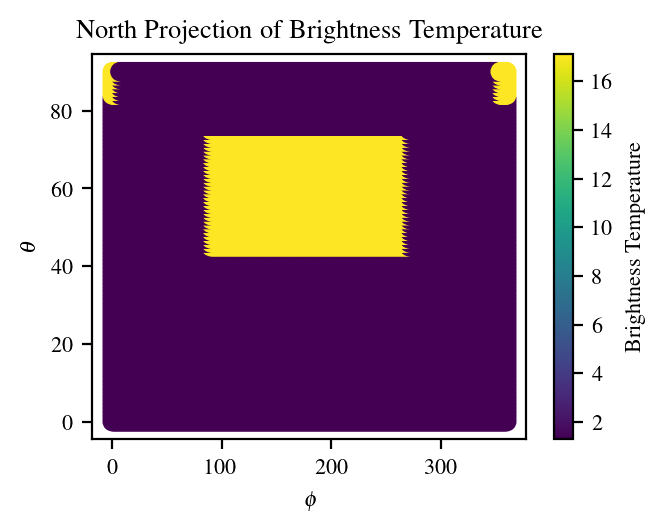

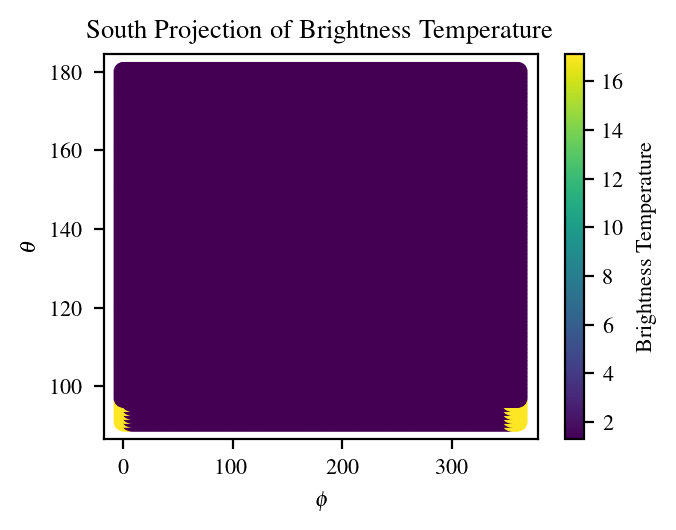

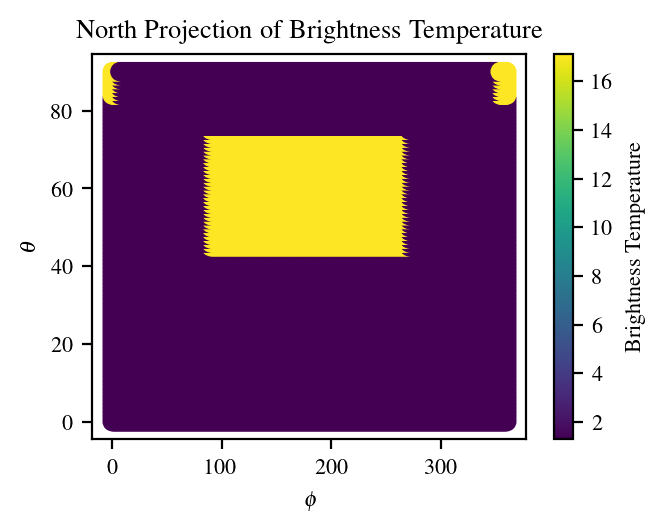

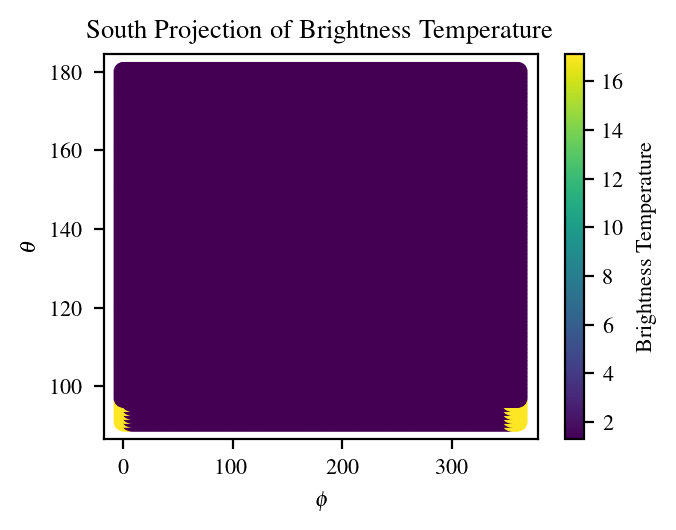

In [20]:
for brightness_temperature in [
    brightness_field_of_europan_sky_vertical_low_band, 
    brightness_field_of_europan_sky_horizontal_low_band, 
    brightness_field_of_europan_sky_vertical_high_band,
    brightness_field_of_europan_sky_horizontal_high_band]:

    # Plotting
    plt.figure()
    plt.scatter(phi_grid[0:91].flatten(), theta_grid[0:91].flatten(), c=10 * np.log10(brightness_temperature[0:91].flatten()), cmap='viridis')
    plt.colorbar(label='Brightness Temperature')
    plt.ylabel(r'$\theta$')
    plt.xlabel(r'$\phi$')
    plt.title('North Projection of Brightness Temperature')

    plt.show()

    # Plotting
    plt.figure()
    plt.scatter(phi_grid[91:].flatten(), theta_grid[91:].flatten(), c=10 * np.log10(brightness_temperature[91:].flatten()), cmap='viridis')
    plt.colorbar(label='Brightness Temperature')
    plt.ylabel(r'$\theta$')
    plt.xlabel(r'$\phi$')
    plt.title('South Projection of Brightness Temperature')

    plt.show()

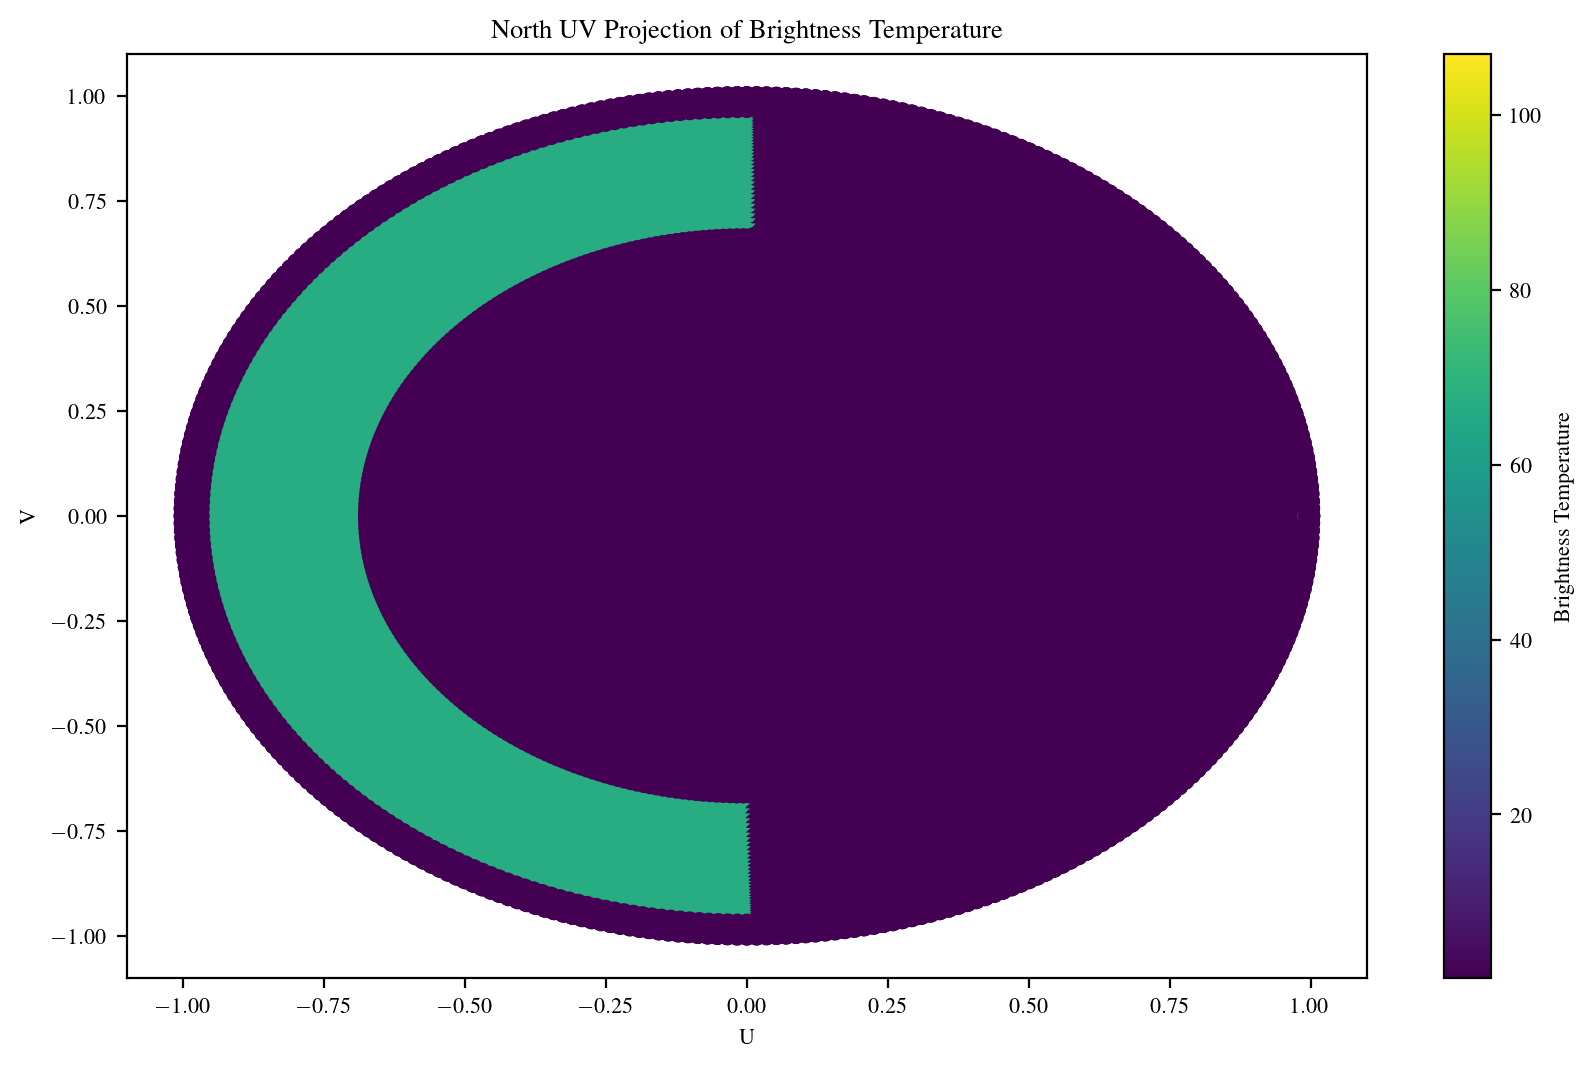

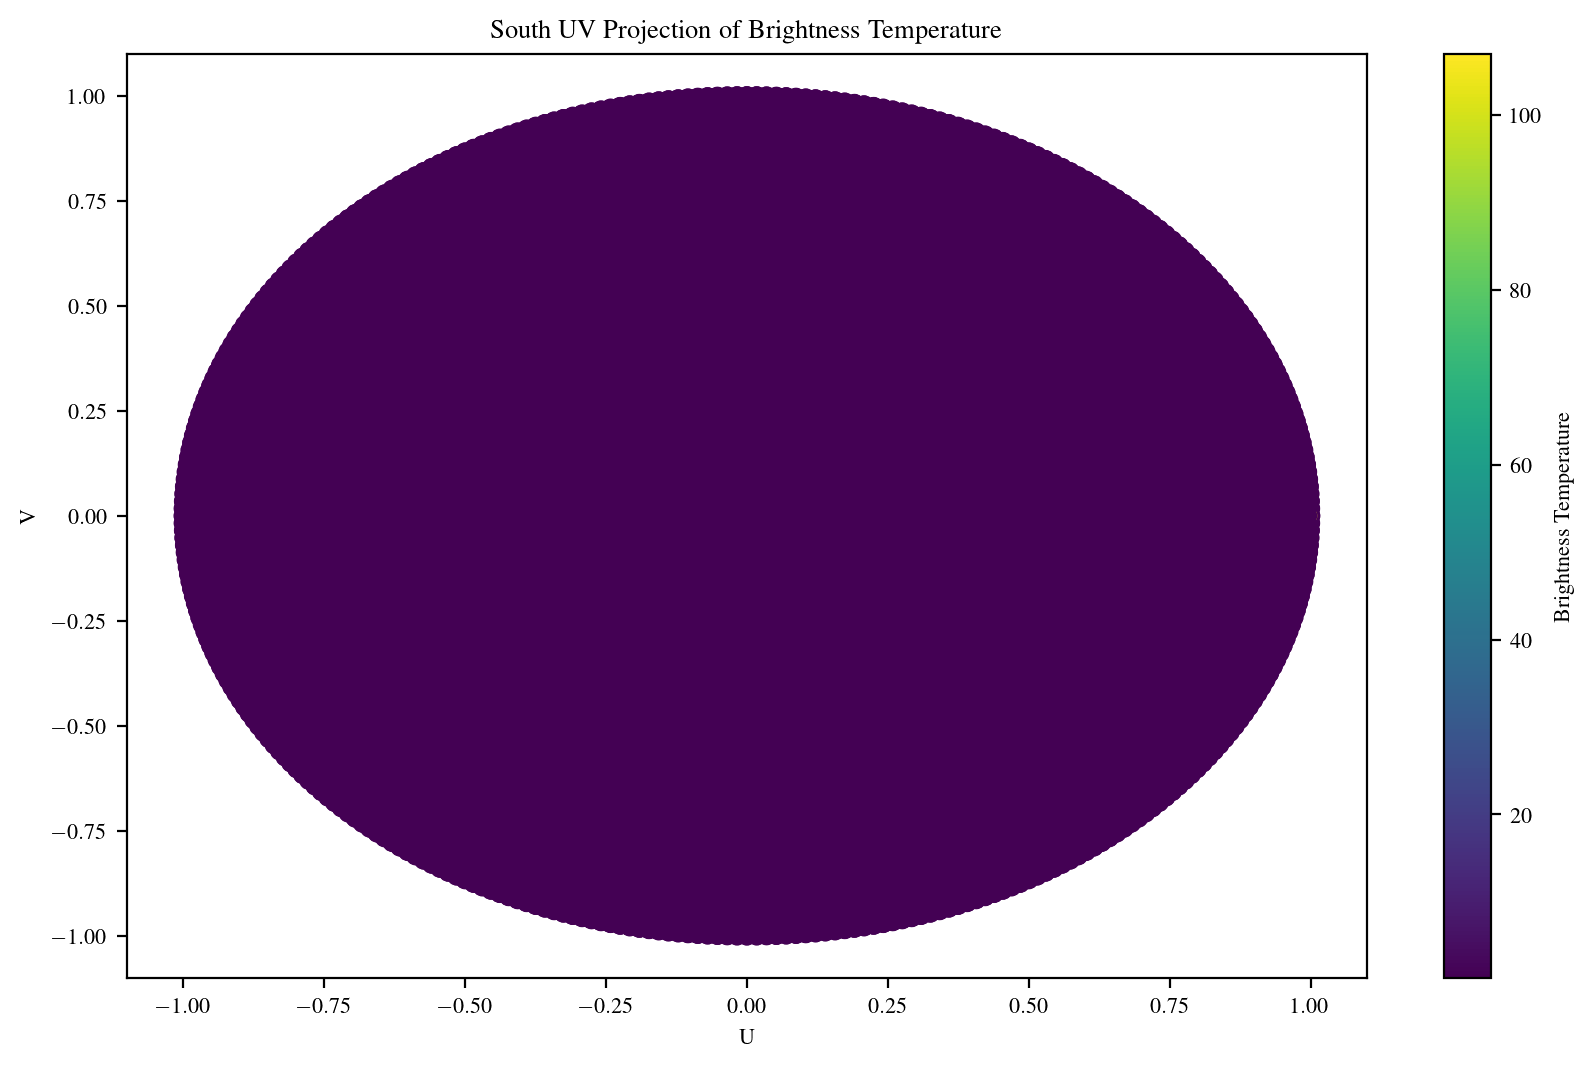

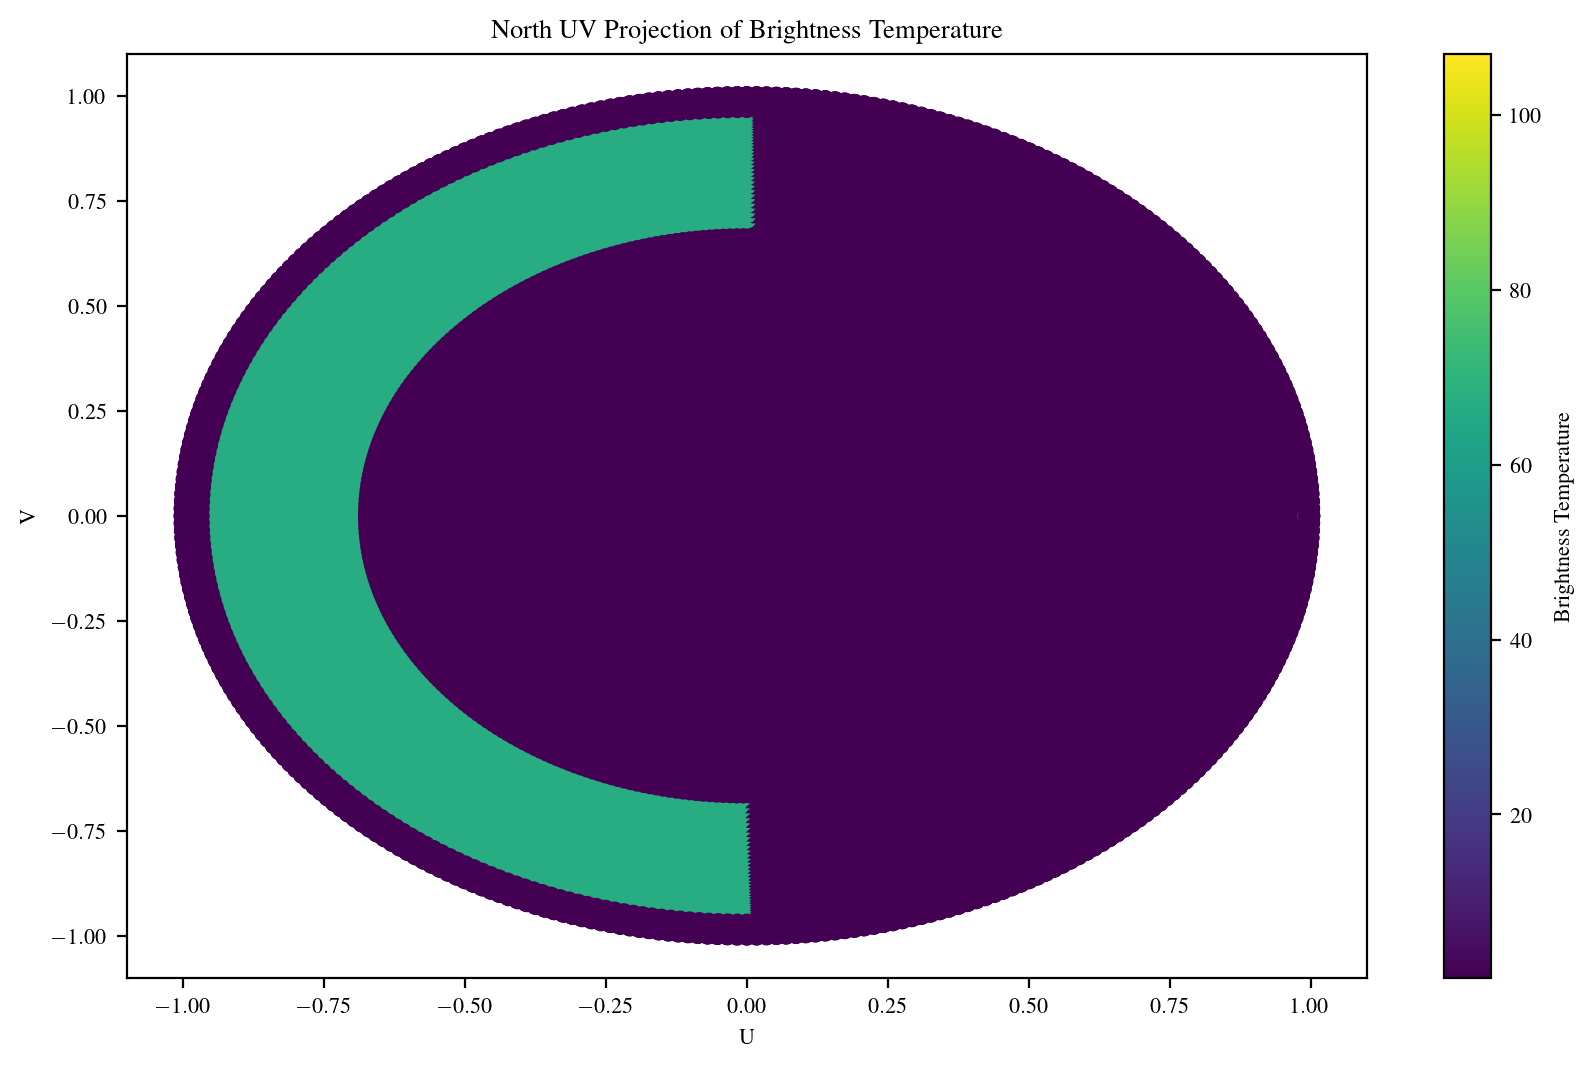

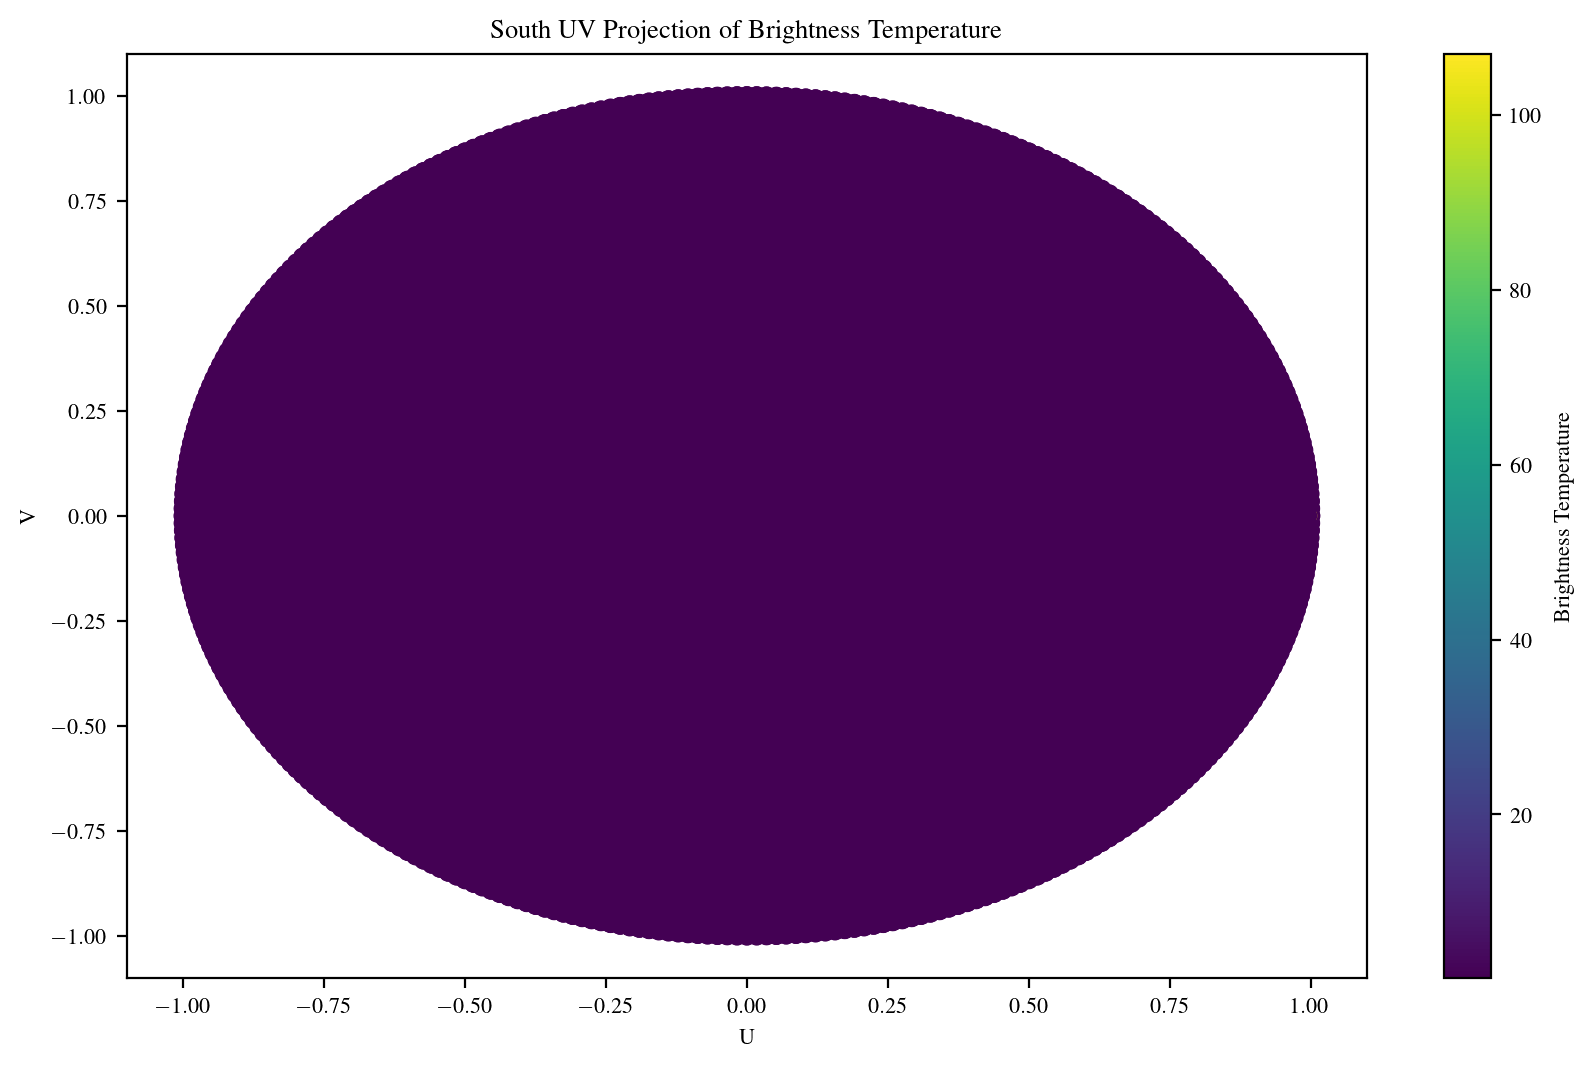

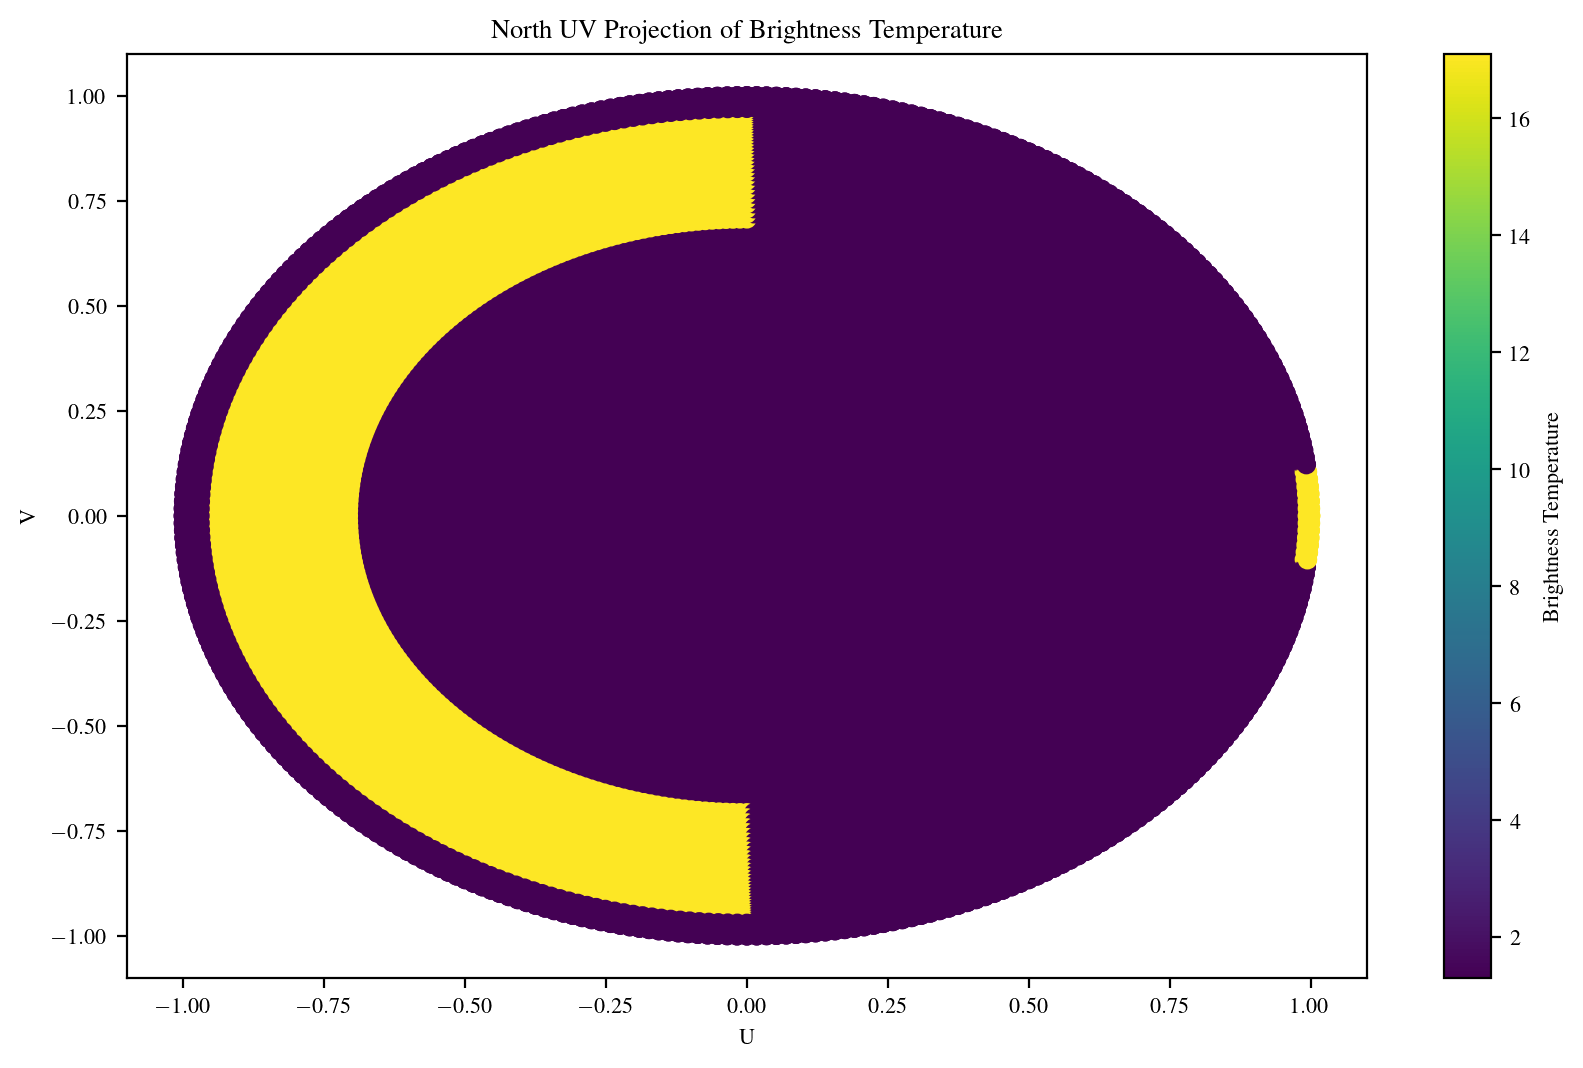

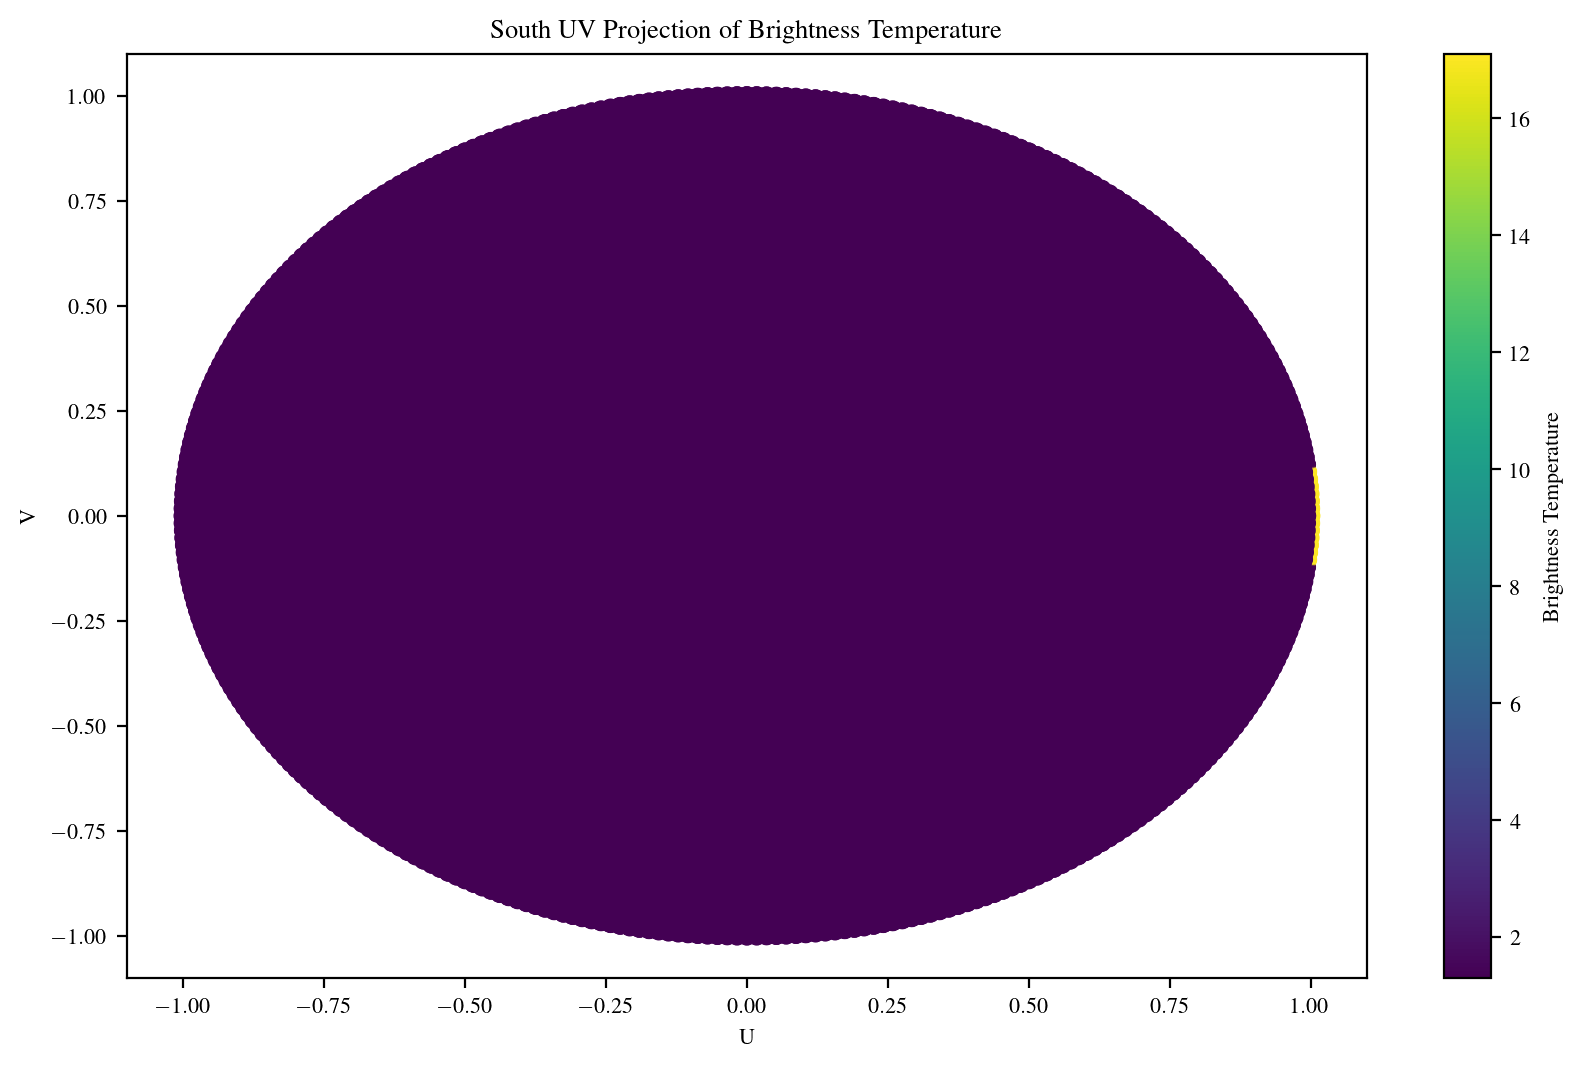

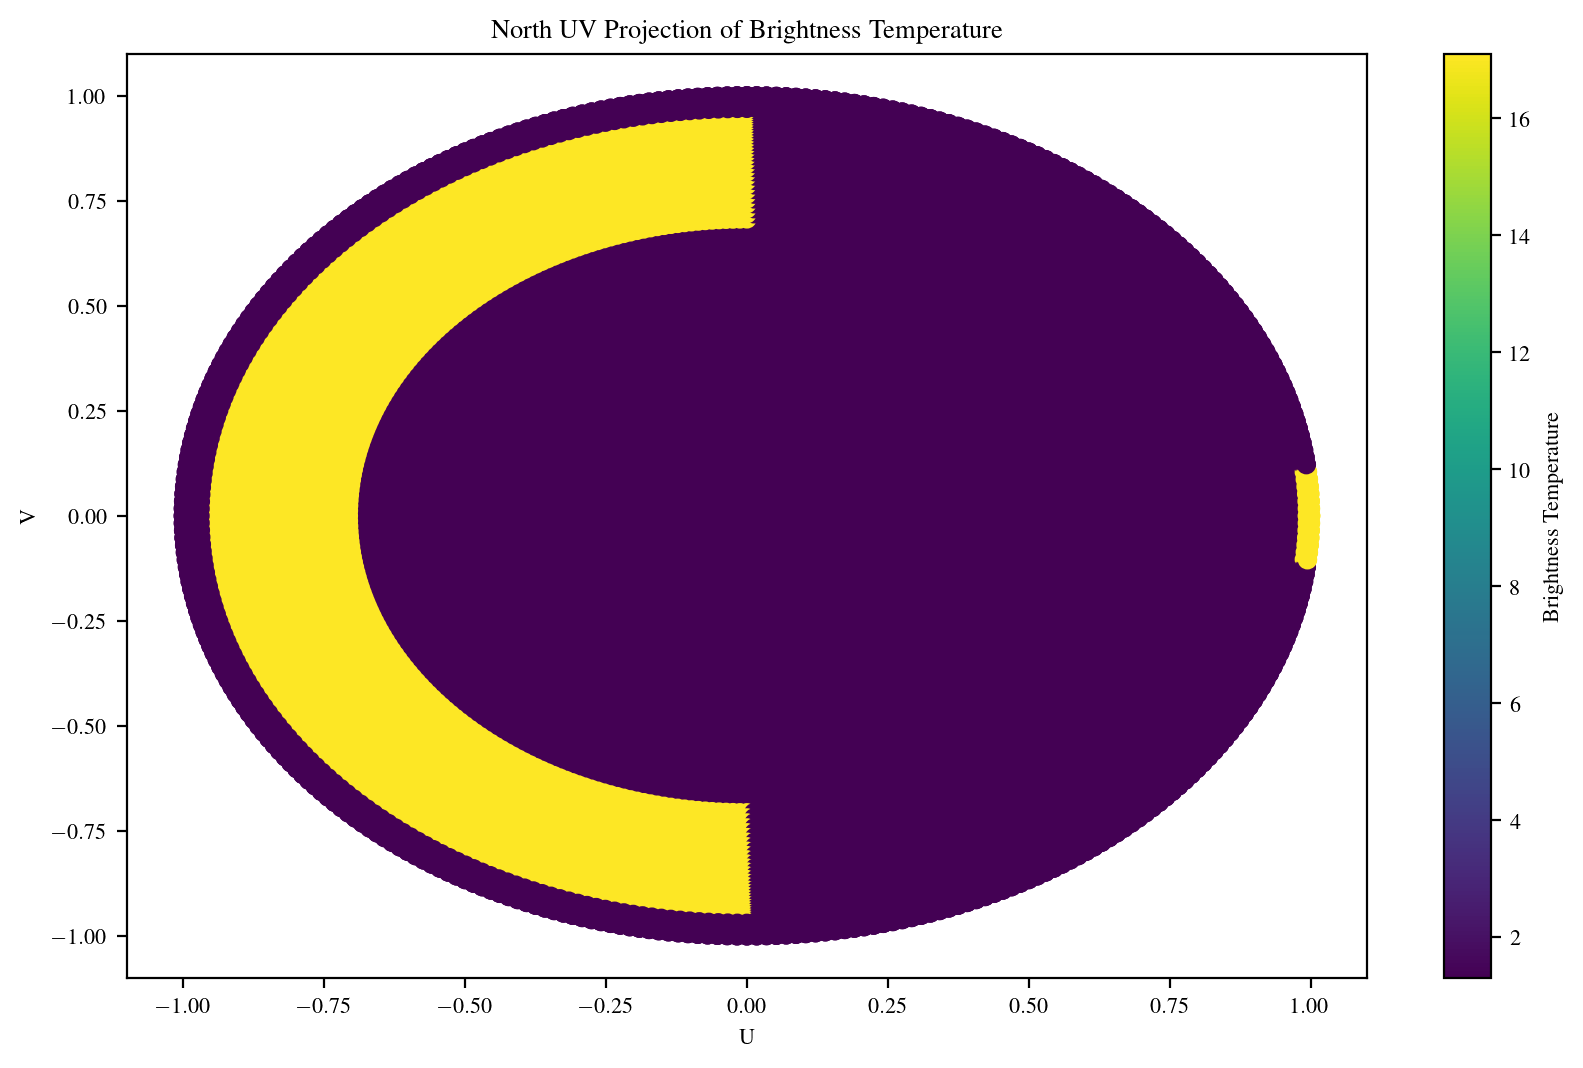

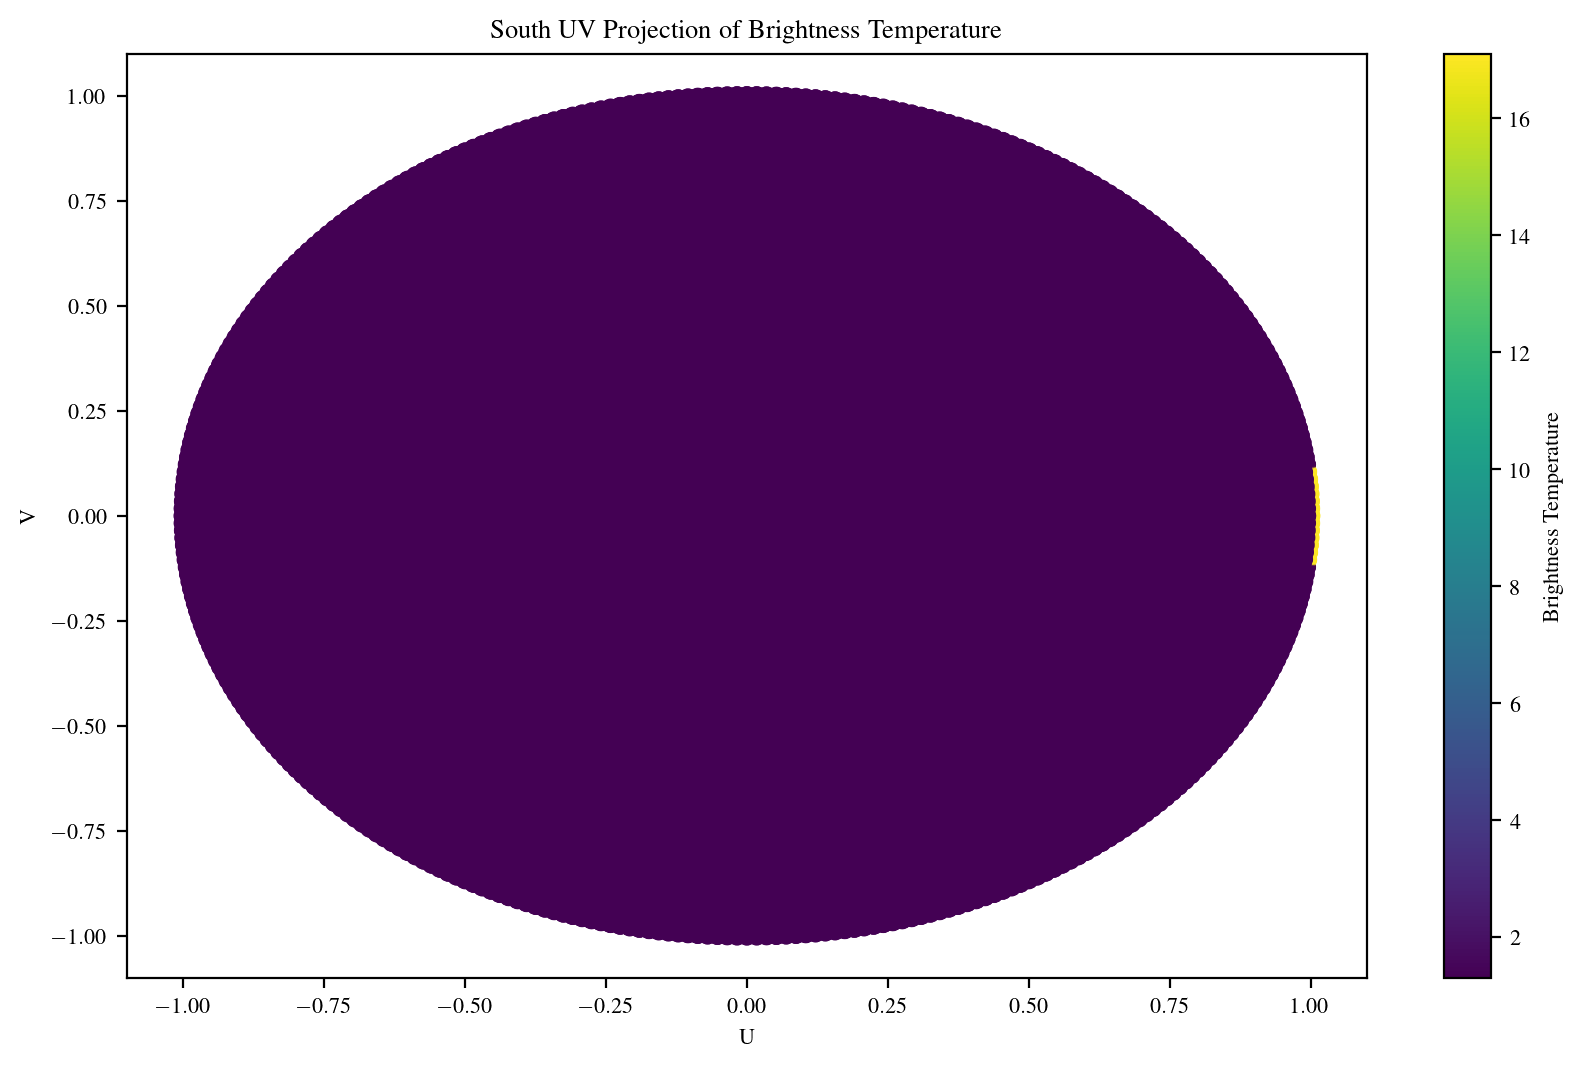

In [21]:
def sind(theta):
    """
    :param theta: angle in degrees
    :return: sine(theta)
    """
    return np.sin(np.deg2rad(theta))


def cosd(theta):
    """
    :param theta:angle in degrees
    :return: cos(theta)
    """
    return np.cos(np.deg2rad(theta))

for brightness_temperature in [
    brightness_field_of_europan_sky_vertical_low_band, 
    brightness_field_of_europan_sky_horizontal_low_band, 
    brightness_field_of_europan_sky_vertical_high_band,
    brightness_field_of_europan_sky_horizontal_high_band]:

    # UV projection
    U = sind(theta_grid[0:91]) * cosd(phi_grid[0:91])
    V = sind(theta_grid[0:91]) * sind(phi_grid[0:91])

    # Plotting
    plt.figure()
    plt.scatter(U.flatten(), V.flatten(), c=10 * np.log10(brightness_temperature[0:91].flatten()), cmap='viridis')
    plt.colorbar(label='Brightness Temperature')
    plt.xlabel('U')
    plt.ylabel('V')
    plt.title('North UV Projection of Brightness Temperature')
    plt.show()

    # UV projection
    U = sind(theta_grid[91:]) * cosd(phi_grid[91:])
    V = sind(theta_grid[91:]) * sind(phi_grid[91:])

    # Plotting
    plt.figure()
    plt.scatter(U.flatten(), V.flatten(), c=10 * np.log10(brightness_temperature[91:].flatten()), cmap='viridis')
    plt.colorbar(label='Brightness Temperature')
    plt.xlabel('U')
    plt.ylabel('V')
    plt.title('South UV Projection of Brightness Temperature')
    plt.show()

In [40]:
# Resample to the 10 deg grid that the antenna pattern is using

# Define the theta and phi sampling grid
theta_resample = np.arange(0, 190, 10) # deg
phi_resample = np.arange(0, 370, 10) # deg

phi_grid_resample, theta_grid_resample  = np.meshgrid(phi_resample, theta_resample)

brightness_field_of_europan_sky_vertical_low_band_resample = np.zeros_like(theta_grid_resample, dtype=float).flatten()
brightness_field_of_europan_sky_horizontal_low_band_resample = np.zeros_like(theta_grid_resample, dtype=float).flatten()
brightness_field_of_europan_sky_vertical_high_band_resample = np.zeros_like(theta_grid_resample, dtype=float).flatten()
brightness_field_of_europan_sky_horizontal_high_band_resample = np.zeros_like(theta_grid_resample, dtype=float).flatten()

for i in np.arange(theta_grid_resample.size):
    theta = theta_grid_resample.flatten()[i]
    phi = phi_grid_resample.flatten()[i]

    theta_range = (theta + np.arange(-5, 5, 1)) % 180
    phi_range = (phi + np.arange(-5, 5, 1)) % 360

    surface_area = 0
    for sub_theta in theta_range:
        for sub_phi in phi_range:
            surface_area += sind(sub_theta) * 1 * 1#steradians
            brightness_field_of_europan_sky_vertical_low_band_resample[i] += brightness_field_of_europan_sky_vertical_low_band[sub_theta, sub_phi]
            brightness_field_of_europan_sky_horizontal_low_band_resample[i] += brightness_field_of_europan_sky_horizontal_low_band[sub_theta, sub_phi]
            brightness_field_of_europan_sky_vertical_high_band_resample[i] += brightness_field_of_europan_sky_vertical_high_band[sub_theta, sub_phi]
            brightness_field_of_europan_sky_horizontal_high_band_resample[i] += brightness_field_of_europan_sky_horizontal_high_band[sub_theta, sub_phi]

    brightness_field_of_europan_sky_vertical_low_band_resample[i] = brightness_field_of_europan_sky_vertical_low_band_resample[i] / surface_area
    brightness_field_of_europan_sky_horizontal_low_band_resample[i] = brightness_field_of_europan_sky_horizontal_low_band_resample[i] / surface_area
    brightness_field_of_europan_sky_vertical_high_band_resample[i] = brightness_field_of_europan_sky_vertical_high_band_resample[i] / surface_area
    brightness_field_of_europan_sky_horizontal_high_band_resample[i] = brightness_field_of_europan_sky_horizontal_high_band_resample[i] / surface_area

brightness_field_of_europan_sky_vertical_low_band_resample = brightness_field_of_europan_sky_vertical_low_band_resample.reshape(theta_grid_resample.shape)
brightness_field_of_europan_sky_horizontal_low_band_resample = brightness_field_of_europan_sky_horizontal_low_band_resample.reshape(theta_grid_resample.shape)
brightness_field_of_europan_sky_vertical_high_band_resample = brightness_field_of_europan_sky_vertical_high_band_resample.reshape(theta_grid_resample.shape)
brightness_field_of_europan_sky_horizontal_high_band_resample = brightness_field_of_europan_sky_horizontal_high_band_resample.reshape(theta_grid_resample.shape)

In [41]:
for brightness_temperature in [
    brightness_field_of_europan_sky_vertical_low_band_resample, 
    brightness_field_of_europan_sky_horizontal_low_band_resample, 
    brightness_field_of_europan_sky_vertical_high_band_resample,
    brightness_field_of_europan_sky_horizontal_high_band_resample]:

    # UV projection
    U = sind(theta_grid_resample[0:9]) * cosd(phi_grid_resample[0:9])
    V = sind(theta_grid_resample[0:9]) * sind(phi_grid_resample[0:9])

    # Plotting
    plt.figure()
    plt.scatter(U.flatten(), V.flatten(), c=10 * np.log10(brightness_temperature[0:9].flatten()), cmap='viridis')
    plt.colorbar(label='Brightness Temperature')
    plt.xlabel('U')
    plt.ylabel('V')
    plt.title('North UV Projection of Brightness Temperature')
    plt.show()

    # UV projection
    U = sind(theta_grid_resample[9:]) * cosd(phi_grid_resample[9:])
    V = sind(theta_grid_resample[9:]) * sind(phi_grid_resample[9:])

    # Plotting
    plt.figure()
    plt.scatter(U.flatten(), V.flatten(), c=10 * np.log10(brightness_temperature[9:].flatten()), cmap='viridis')
    plt.colorbar(label='Brightness Temperature')
    plt.xlabel('U')
    plt.ylabel('V')
    plt.title('South UV Projection of Brightness Temperature')
    plt.show()

ValueError: operands could not be broadcast together with shapes (9,37) (9,361) 

(array([175, 176, 177, 178, 179,   0,   1,   2,   3,   4]),
 array([355, 356, 357, 358, 359,   0,   1,   2,   3,   4]))